## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetimes = c['livetimes']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
nbidx = 2


In [4]:
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{c['livetime']}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz


## Datasets

In [5]:
def set_up(dataset_input):
    
    setup = Setup(dataset_input=dataset_input)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset_asimov, dataset_asimov_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_asimov_N)
    if sys == "Eff_area":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = True
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

    # piece wise model
    # remove old bkg model
    #setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
    #setup.set_piecewise_bkg_model(dataset_asimov_N)
    # energy of the following parameters smaller than ethrshold
    #dataset_asimov_N.background_model.parameters['norm0'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm1'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm2'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm3'].frozen = True
    #setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)

    
       
    return dataset_asimov_N, dataset_asimov

In [6]:
datasets_N = []
datasets = []
for n in range(len(livetimes)):
    dataset_asimov_N, dataset_asimov = set_up(dataset_input)
    datasets_N.append(dataset_asimov_N)
    datasets.append(dataset_asimov)

In [7]:
print("read")
for i, d in enumerate(datasets):
    print(i)
    path = f'../{folder}/data/0_model_livetime_{livetimes[i]}.yml'
    datasets[i].models = Models.read(path)
for i, d in enumerate(datasets_N):
    print(i)
    path = f'../{folder}/data/0_model_nui_livetime_{livetimes[i]}.yml'
    print(path)
    datasets_N[i] = Dataset_load.load_dataset_N(d, path,bkg_sys = False)        
    datasets_N[i].models.parameters['tilt'].frozen = False 
    


read
0
1
2
3
4
5
6
7
8
9
10
11
12
0
../Eff_area_PKSflare_crab_log/data/0_model_nui_livetime_0.01.yml
1
../Eff_area_PKSflare_crab_log/data/0_model_nui_livetime_0.021544346900318832.yml
2
../Eff_area_PKSflare_crab_log/data/0_model_nui_livetime_0.046415888336127774.yml
3
../Eff_area_PKSflare_crab_log/data/0_model_nui_livetime_0.1.yml
4
../Eff_area_PKSflare_crab_log/data/0_model_nui_livetime_0.21544346900318834.yml
5
../Eff_area_PKSflare_crab_log/data/0_model_nui_livetime_0.46415888336127775.yml
6
../Eff_area_PKSflare_crab_log/data/0_model_nui_livetime_1.0.yml
7
../Eff_area_PKSflare_crab_log/data/0_model_nui_livetime_2.154434690031884.yml
8
../Eff_area_PKSflare_crab_log/data/0_model_nui_livetime_4.641588833612778.yml
9
../Eff_area_PKSflare_crab_log/data/0_model_nui_livetime_10.0.yml
10
../Eff_area_PKSflare_crab_log/data/0_model_nui_livetime_21.544346900318832.yml
11
../Eff_area_PKSflare_crab_log/data/0_model_nui_livetime_46.41588833612777.yml
12
../Eff_area_PKSflare_crab_log/data/0_model_n

## RND Fluxpoints

In [9]:
infos = np.loadtxt(f"../{c['folder']}/data/1_P_draw_info.txt")
N_max = 100
shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
res_rnds = infos[:N_max, 2]
bias_rnds = infos[:N_max, 3]


pars_N = np.loadtxt(f"../{c['folder']}/data/1_N_P_draw_par.txt")
lives = pars_N[:N_max, -1:]

fpd_Ns, fpd_s = [], []

for i in range(len(shift_rnds)):
    s = shift_rnds[i]
    t = index_rnds[i]
    r = res_rnds[i]
    b = bias_rnds[i]
    rnds = f"{s:.6}_{t:.6}_{r:.6}_{b:.6}"
    l = lives[i][0]
    print(l)
    try:
        fluxpoints = FluxPoints.read(
            f"../{c['folder']}/data/fluxpoints/1P_fluxpoints_{l}_{rnds}.fits"
        )
        fluxpoints_N = FluxPoints.read(
            f"../{c['folder']}/data/fluxpoints/1P_fluxpoints_N_{l}_{rnds}.fits"
        )
        model_name = f"../{c['folder']}/data/fluxpoints/1P_model_N_{l}_{rnds}.yaml"
        fluxpoints_Nds = FluxPointsDataset(data=fluxpoints_N, models=Models.read(model_name))
        model_name = f"../{c['folder']}/data/fluxpoints/1P_model_{l}_{rnds}.yaml"
        fluxpoints_ds = FluxPointsDataset(data=fluxpoints, models=Models.read(model_name))
        fpd_Ns.append(fluxpoints_Nds)
        fpd_s.append(fluxpoints_ds)
    except:
        j = 0 
    


4.641588833612778
21.544346900318832
0.01
0.046415888336127774
0.046415888336127774
1.0
0.21544346900318834
1.0
0.21544346900318834
0.1
0.1
2.154434690031884
2.154434690031884
0.46415888336127775
0.46415888336127775
0.021544346900318832
0.01
0.021544346900318832
2.154434690031884
2.154434690031884


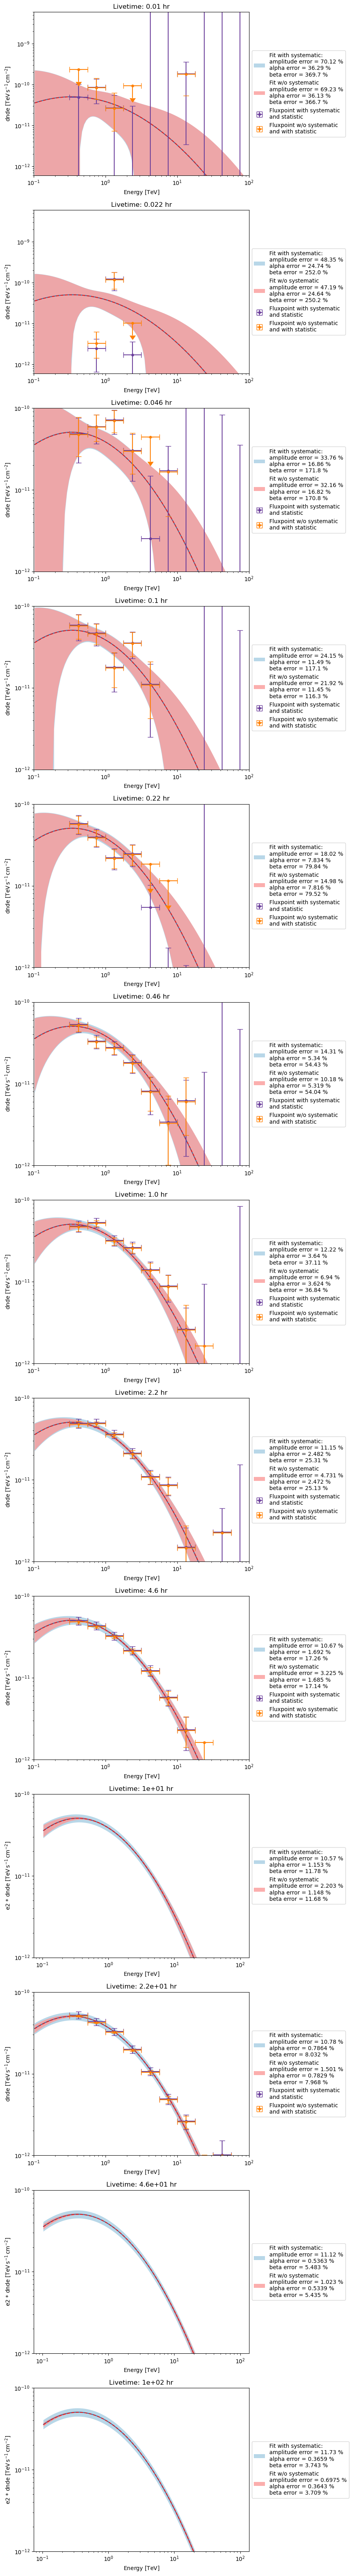

In [11]:
def plot_spectra():
    fig,axs = plt.subplots(len(datasets), 1, figsize = (9, 5 * len(datasets)))
    axs= axs.flatten()
    energy_power = 2
    for i, d in enumerate(datasets):
        ax = axs[i]
        live = livetimes[i]
        dataset = datasets[i]
        dataset_N = datasets_N[i]

        dataset_N.models[0].spectral_model.plot((0.1, 100) *u.TeV, energy_power = energy_power,
                                                     color = aw[0], ax = ax)    
        paris = [p.name for p in dataset_N.models[0].spectral_model.parameters.free_parameters]
        def info(dataset):
            info = ""
            for p in paris:
                par = dataset.models[0].parameters[p]
                per = par.error /par.value
                info += f"\n{p} error = {per*100:.4} %"
            return info
        dataset_N.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   facecolor= aw[1], alpha = 0.8, 
                                                     label = f'Fit with systematic: {info(dataset_N)}')
        dataset.models[0].spectral_model.plot((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   color= awo[0], linestyle = 'dashed')
       
        dataset.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   facecolor= awo[1], alpha = 0.8,
                                                   label = f'Fit w/o systematic{info(dataset)}')
        ax.set_title(f"Livetime: {float(live):.2} hr")
        ax.set_ylim(1e-12, 1e-10)

        if i <2:
            ax.set_ylim(6e-13, 6e-9)
            
        
        if live in lives:
            idx = np.where(live == lives)[0][0]
            fpd_Ns[idx].data.plot(ax = ax, energy_power = energy_power, color = ew[0],
                                 label = "Fluxpoint with systematic \nand statistic",
                                 capsize = 5)
            fpd_s[idx].data.plot(ax = ax, energy_power = energy_power, color = ewo[0],
                                label = "Fluxpoint w/o systematic \nand with statistic",
                                capsize = 5)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    return fig
        
fig = plot_spectra()
fig.savefig(f'../{folder}/plots/{nbidx}_spectra_with_rnd_fp.pdf')

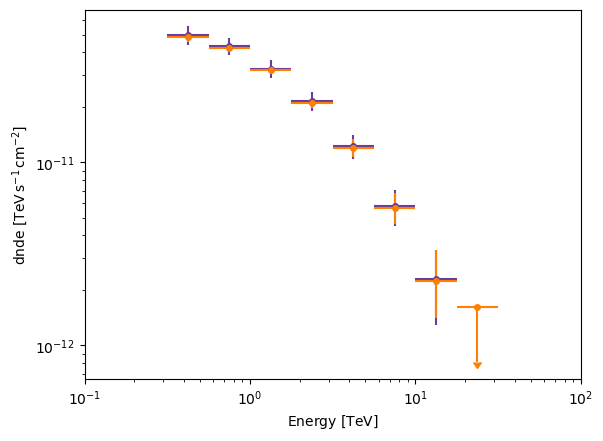

In [12]:
live = lives[0]
energy_power = 2
if live in lives:
    idx = np.where(live == lives)[0][-1]
    fpd_Ns[idx].data.plot( energy_power = energy_power, color = ew[0],
                         label = "Example fluxpoint with nui par.")
    fpd_s[idx].data.plot( energy_power = energy_power, color = ewo[0],
                         label = "Example fluxpoint with nui par.")

In [13]:
fpd_s[idx].models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1,object
spectral,amplitude,3.7938e-11,cm-2 s-1 TeV-1,1.235e-12,nan,nan,False,True,,None
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,None
spectral,alpha,2.4870e+00,,4.298e-02,nan,nan,False,False,,None
spectral,beta,2.3883e-01,,4.141e-02,nan,nan,False,False,,None
spatial,lon_0,3.2968e+02,deg,1.612e-03,3.287e+02,3.307e+02,False,False,,None
spatial,lat_0,-3.0222e+01,deg,1.381e-03,-3.122e+01,-2.922e+01,False,False,,None


In [14]:
fpd_s[idx].data.dnde_ref.flatten()

<Quantity [2.15856176e-09, 8.29153528e-10, 2.71871980e-10, 7.60944482e-11,
           1.81802779e-11, 3.70772133e-12, 6.45464971e-13, 9.59173772e-14,
           1.21669279e-14, 1.31741802e-15, 1.21765789e-16, 9.60696035e-18] 1 / (cm2 s TeV)>

In [15]:
fpd_Ns[idx].models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1,object
spectral,amplitude,3.7957e-11,cm-2 s-1 TeV-1,4.061e-12,nan,nan,False,True,,None
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,None
spectral,alpha,2.4894e+00,,4.322e-02,nan,nan,True,False,,None
spectral,beta,2.3882e-01,,4.172e-02,nan,nan,True,False,,None
spatial,lon_0,3.2968e+02,deg,1.611e-03,3.287e+02,3.307e+02,True,False,,None
spatial,lat_0,-3.0222e+01,deg,1.381e-03,-3.122e+01,-2.922e+01,True,False,,None


In [16]:
fpd_Ns[idx].data.dnde_ref.flatten()

<Quantity [2.17029293e-09, 8.32490018e-10, 2.72584138e-10, 7.61873719e-11,
           1.81771701e-11, 3.70194887e-12, 6.43569461e-13, 9.55039437e-14,
           1.20978459e-14, 1.30814432e-15, 1.20743605e-16, 9.51335014e-18] 1 / (cm2 s TeV)>

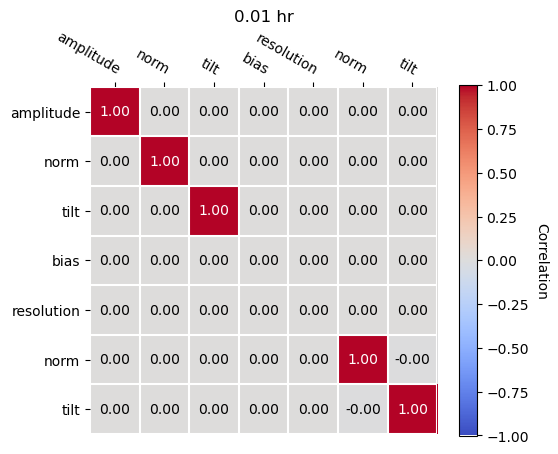

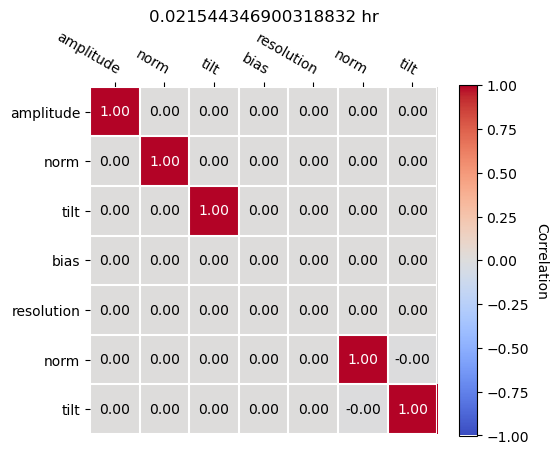

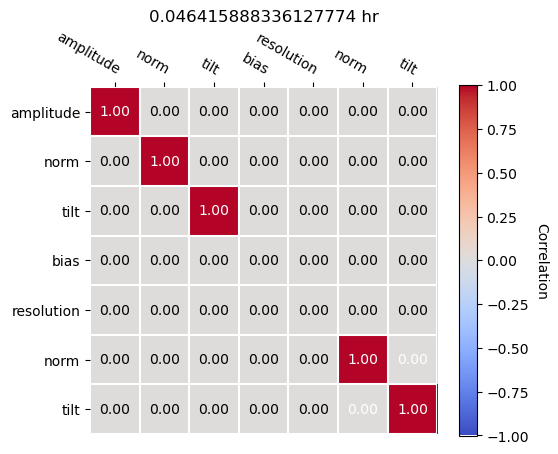

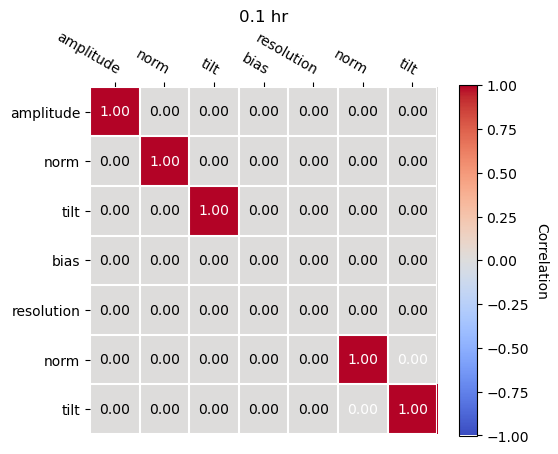

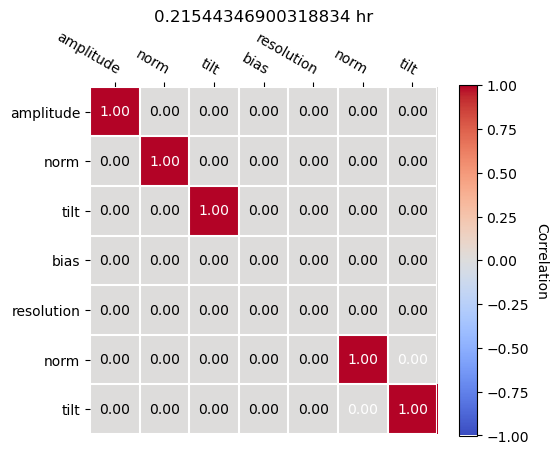

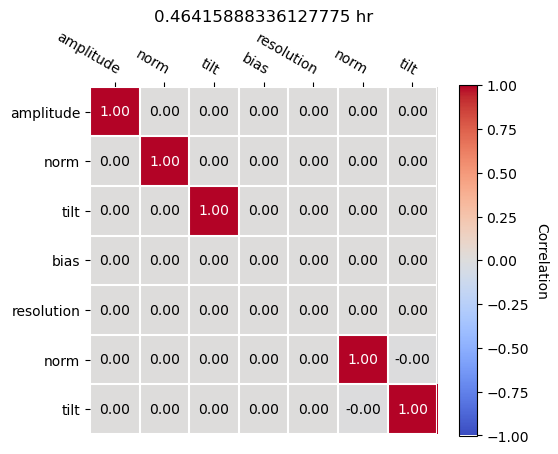

In [ ]:
par_names = ['index', 'amplitude', 'lambda_', 'bias', 'resolution', 'norm' , 
            'tilt']
names =  ['index', 'amplitude',  
        'bkg norm', 'bkg tilt',
          'bias', 'resolution',
          'eff. area norm' , 
            'eff. area tilt']
for i in range(len(livetimes)):

    #datasets_N[i].models.read_covariance("data", f"8_model_nui_livetime_{livetimes[i]}_covariance.dat", format="ascii.fixed_width")
    parameters = Parameters([_ for _ in datasets_N[i].models.parameters if _.name in par_names])
    cov_par = datasets_N[i].models.covariance.get_subcovariance(parameters)
    ax = cov_par.plot_correlation()
    ax.set_title(str(livetimes[i]) + " hr")
    fig = plt.gcf()
    fig.savefig(f'../{folder}/plots/{nbidx}_covmatrix_livetime_{livetimes[i]}.svg')
    fig.savefig(f'../{folder}/plots/{nbidx}_covmatrix_livetime_{livetimes[i]}.pdf')
    
